In [209]:
import sys
import os
if '__file__' in locals():
    current_script_dir = os.path.dirname(os.path.abspath(__file__))
else:
    current_script_dir = os.getcwd() 
project_root = os.path.abspath(os.path.join(current_script_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
from scripts.core_imports import *


# --------------- Downscaling---------------------

## a) Training: 1960-1980:

In [144]:
data_dir = r"C:\Users\hdagne1\Box\Dr.Mesfin Research\Codes\HighRes_County_level_LivestockWaterUse_CONUS_dataset\Results"

In [145]:
County_Level_Dairy_Cattle_WC_WW_1985_2022 = pd.read_feather(os.path.join(data_dir, "County_Level_Dairy_Cattle_WC_WW_1985_2022.feather"))
County_Level_Beef_Cattle_WC_WW_1985_2022 = pd.read_feather(os.path.join(data_dir, "County_Level_Beef_Cattle_WC_WW_1985_2022.feather"))
County_Level_Hogs_WC_WW_1985_2022 = pd.read_feather(os.path.join(data_dir, "County_Level_Hogs_WC_WW_1985_2022.feather"))
County_Level_Poultry_WC_WW_1985_2022 = pd.read_feather(os.path.join(data_dir, "County_Level_Poultry_WC_WW_1985_2022.feather"))


shapefile_path = r'C:\Users\hdagne1\Box\Dr.Mesfin Research\Data\CONUS_geometries\CONUS_Counties\CONUS_Counties.shp'
CONUS_counties = gpd.read_file(shapefile_path)

# CONUS_counties.plot()
# plt.tight_layout()
# plt.show()
CONUS_counties.rename(columns={'NAME': 'COUNTY_NAME'}, inplace=True)
CONUS_counties['COUNTY_NAME'] = CONUS_counties['COUNTY_NAME'].str.upper()
CONUS_counties['STATE_NAME']  = CONUS_counties['STATE_NAME'].str.upper()

CONUS_counties['COUNTY_NAME'] = CONUS_counties['COUNTY_NAME'].str.replace(' COUNTY', '').str.upper()

# --- Columns to drop from CONUS_counties after merge ---
cols_to_drop = [
    'STATE_FIPS','CNTY_FIPS','FIPS','POPULATION','POP_SQMI','POP2010','POP10_SQMI',
    'WHITE','BLACK','AMERI_ES','ASIAN','HAWN_PI','HISPANIC','OTHER','MULT_RACE','MALES','FEMALES',
    'AGE_UNDER5','AGE_5_9','AGE_10_14','AGE_15_19','AGE_20_24','AGE_25_34','AGE_35_44','AGE_45_54',
    'AGE_55_64','AGE_65_74','AGE_75_84','AGE_85_UP','MED_AGE','MED_AGE_M','MED_AGE_F','HOUSEHOLDS',
    'AVE_HH_SZ','HSEHLD_1_M','HSEHLD_1_F','MARHH_CHD','MARHH_NO_C','MHH_CHILD','FHH_CHILD','FAMILIES',
    'AVE_FAM_SZ','HSE_UNITS','VACANT','OWNER_OCC','RENTER_OCC','NO_FARMS12','AVE_SIZE12','CROP_ACR12',
    'AVE_SALE12','SQMI','NO_FARMS17','AVE_SIZE17','CROP_ACR17','AVE_SALE17','Shape_Leng','Shape_Area',
    'STATE_NA_1','DRAWSEQ','STATE_FI_1','SUB_REGION','STATE_ABBR','Area_SKM', 'STATE_NAME'
]

# --- Ensure COUNTY_NAME and STATE_NAME are uppercase in livestock data ---
def prepare_livestock_for_merge(df):
    df['COUNTY_NAME'] = df['COUNTY_NAME'].str.upper()
    df['STATE_NAME'] = df['State_Name'].str.upper() if 'State_Name' in df.columns else df.get('STATE_NAME', df['COUNTY_NAME'])
    return df

# --- Deduplicate CONUS_counties by COUNTY_NAME + STATE_NAME ---
CONUS_counties_unique = CONUS_counties.drop_duplicates(subset=['COUNTY_NAME', 'STATE_NAME'])

def merge_with_counties(livestock_df):
    # Prepare livestock dataframe
    livestock_df = prepare_livestock_for_merge(livestock_df)

    # Merge on COUNTY_NAME and STATE_NAME
    merged_df = livestock_df.merge(
        CONUS_counties_unique,
        on=['COUNTY_NAME', 'STATE_NAME'],
        how='left',
        validate='m:1'  # many-to-one merge
    )

    # Drop unnecessary columns
    merged_df = merged_df.drop(columns=[c for c in cols_to_drop if c in merged_df.columns], errors='ignore')
    return merged_df

# --- Example usage ---
County_Level_Dairy_Cattle_WC_WW_1985_2022_geo = merge_with_counties(County_Level_Dairy_Cattle_WC_WW_1985_2022)
County_Level_Beef_Cattle_WC_WW_1985_2022_geo = merge_with_counties(County_Level_Beef_Cattle_WC_WW_1985_2022)
County_Level_Hogs_County_WC_WW_1985_2022_geo = merge_with_counties(County_Level_Hogs_WC_WW_1985_2022)
County_Level_Poultry_WC_WW_1985_2022_geo = merge_with_counties(County_Level_Poultry_WC_WW_1985_2022)

# Plotting The results:

## a) Downscaled Ratio (WC-to-WW):

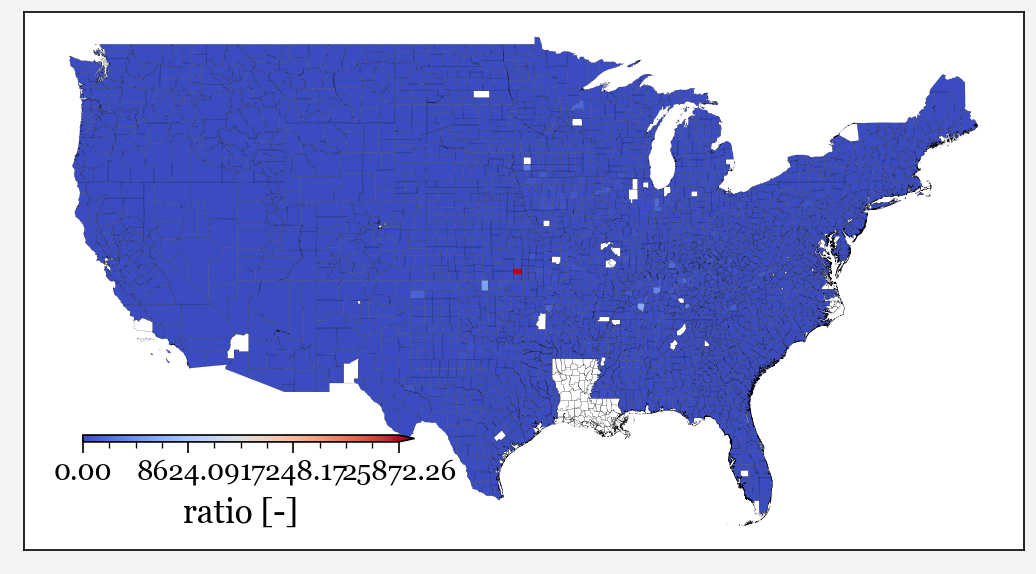

In [221]:
plt.rcParams['font.family'] = 'Georgia'

years_to_plot = [1985]
col_to_plot = 'CL_WW'
# title_name = 'b) Beef Cattle'

for year_to_filter in years_to_plot:
    # Filter by year
    merged_gdf = County_Level_Beef_Cattle_WC_WW_1985_2022_geo[
        County_Level_Beef_Cattle_WC_WW_1985_2022_geo['Year'] == year_to_filter
    ].copy()

    # Ensure GeoDataFrame with geometry
    merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')
    
    # Align CRS with CONUS counties
    merged_gdf = merged_gdf.set_crs(CONUS_counties.crs)

    fig, ax = pplt.subplots(refwidth=5, facecolor="w")#, dpi=200)

    # Plot polygons
    merged_gdf.plot(
        ax=ax,
        column=col_to_plot,
        cmap="coolwarm",
        legend=False
    )

    # Overlay county boundaries
    CONUS_counties.boundary.plot(ax=ax, edgecolor='black', linewidth=0.05)

    # Colorbar
    vmin, vmax = merged_gdf[col_to_plot].min(), merged_gdf[col_to_plot].max()
    sm = mpl.cm.ScalarMappable(cmap="coolwarm", norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    ticks = np.linspace(vmin, vmax, 4)
    cbar_ax = fig.add_axes([0.08, 0.23, 0.32, 0.012])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', extend='max', ticks=ticks)
    cbar.set_label(f"ratio [-]", fontsize=12)
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.set_xticklabels([f"{t:.2f}" for t in ticks], fontsize=10)

    # Title
    # ax.set_title(fontsize=12, fontweight='bold', loc='left')

    # Keep border but remove lat/lon ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Keep rectangular border
    for spine in ax.spines.values():
        spine.set_visible(True)

    plt.show()
